In [1]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
def generate_graph(data_list, xaxis, yaxis, save=False, legend_outside=False):
    if isinstance(xaxis, tuple):
        xaxis_measure, xaxis_title = xaxis
    else:
        xaxis_measure, xaxis_title = [xaxis] * 2
    if isinstance(yaxis, tuple):
        yaxis_measure, yaxis_title = yaxis
    else:
        yaxis_measure, yaxis_title = [yaxis] * 2

#     scale = scale_color_brewer(type='qual', palette=1)
#     d3.schemeCategory20
#     ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896",
#      "#9467bd", "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7",
#      "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"]
#     colors = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a",
#               "#d62728", "#ff9896", "#9467bd", "#c5b0d5", "#8c564b", "#c49c94",
#               "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22", "#dbdb8d",
#               "#17becf", "#9edae5"]

    shapes = ['o', 'D', 's', '*', '^', 'v', '<', '>', 'p', 'X', 'P']

    # with plt.style.context('seaborn'):  # optional
    fig, plots = plt.subplots(ncols=len(data_list), squeeze=False, figsize=(20, 6))
    legends = []
    for plot, (title, data) in zip(plots[0], data_list):
        filled_counter = 0
        for i, (name, group, do_fill) in enumerate(data):
            if do_fill:
                additional_params = dict()
                shp_index = filled_counter
                filled_counter += 1
            else:
                additional_params = dict(mfc='none')
                shp_index = i - filled_counter
            plot.plot(group[xaxis_measure], group[yaxis_measure], shapes[shp_index], label=name,
                  #c=colors[i],
                  **additional_params)
        plot.set_xlabel(xaxis_title)
        plot.set_ylabel(yaxis_title)
        plot.set_title(title)
        plot.grid()
        if legend_outside:
            legends.append(plot.legend(loc='upper left', bbox_to_anchor=(1, 1)))
        else:
            plot.legend()
    if save:
        save_path = Path("results") / Path("analysis") / Path(title)
        save_path.mkdir(parents=True, exist_ok=True)
        figure_path = str(save_path / Path(f"{xaxis_measure}-{yaxis_measure}.png"))
        if legend_outside:
            fig.savefig(figure_path, bbox_extra_artists=legends, bbox_inches='tight')
        else:
            fig.savefig(figure_path)
        # print(xaxis_measure, yaxis_measure)

In [3]:
def parse(filename, condition=None, mapping=None):
    """Parse a file
    
    You can pass a function as `condition` that decides whether a given
    algorithm should be included.
    You can pass a function as `mapping` that changes the algorithm names
    
    Args:
        filename: a string with the filename
        condition: (optional) a function that takes an algorithm name
                   and returns True or False (i.e. a predicate)
        mapping: (optional) a function that takes an algorithm name
                 and returns a replacement name and a boolean that decides
                 if the corresponding marker is filled or not
    Returns:
        a list of tuples of algorithm name, Pandas dataframe and fill indicator
    """
    no_cond = (condition is None)
    no_map = (mapping is None)
    raw_data = pd.read_csv(filename)
    to_plot = []
    for algo_name, values in raw_data.groupby('algorithm'):
        if no_cond or condition(algo_name):
            new_algo_name, do_fill = (algo_name, True) if no_map else mapping(algo_name)
            to_plot.append((new_algo_name, values, do_fill))
    return to_plot

In [4]:
def parse_all(filenames_and_titles, condition=None, mapping=None):
    return [(title, parse(filename, condition, mapping))
            for filename, title in filenames_and_titles]

In [5]:
def plot_all(filenames_and_titles, xaxis, yaxis, condition=None, mapping=None):
    data = parse_all(filenames_and_titles, condition, mapping)
    generate_graph(data, xaxis, yaxis)

In [6]:
def start_filter(startwith):
    def filt(x):
        return x.startswith(startwith)
    return filt

In [7]:
graphs = [('DIbinary', 'accuracy')]
adult_datafiles = [
    ('../../results/parity_tar/adult_race_numerical-binsensitive.csv', 'Adult (race)'),
    ('../../results/parity_tar/adult_sex_numerical-binsensitive.csv', 'Adult (sex)'),
]

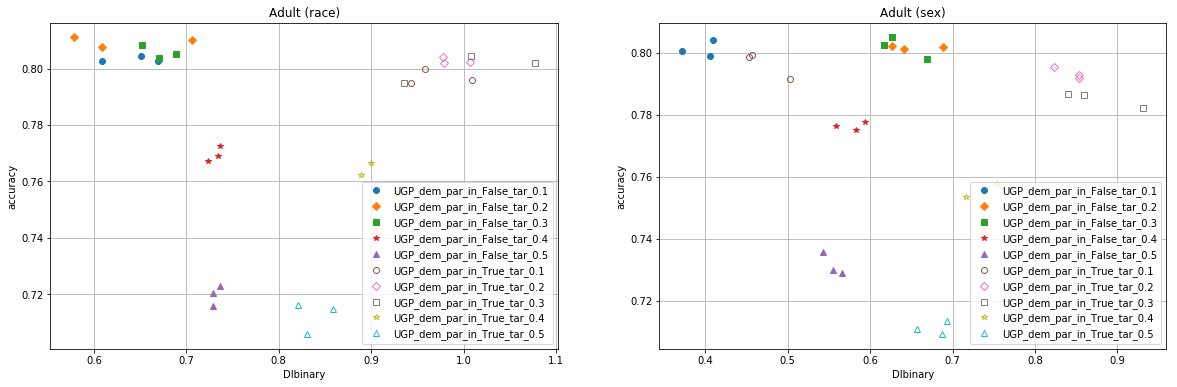

In [13]:
def unfill_in_true(label):
    return label, label.startswith('UGP_dem_par_in_False')

for xaxis, yaxis in graphs:
    plot_all(adult_datafiles, xaxis, yaxis, mapping=unfill_in_true)
plt.show()

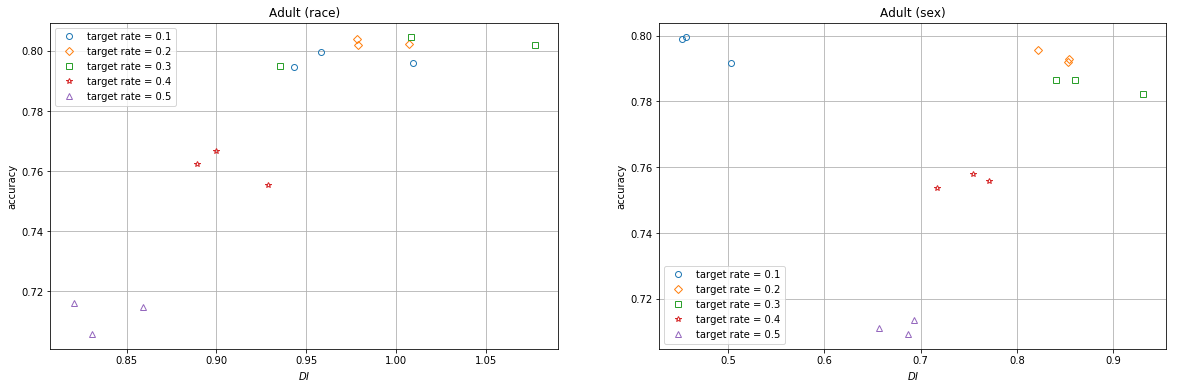

In [9]:
def label_change(label):
    num = label.split('_')[-1]
    return f"target rate = {num}", False

data = parse_all(adult_datafiles, start_filter('UGP_dem_par_in_True'), label_change)
generate_graph(data, ('DIbinary', '$DI$'), 'accuracy')